In [69]:
### IMPORTS / DEPENDENCIES:

# PLOTTING:
import matplotlib as mpl
import matplotlib.pyplot as plt

# DATA:
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax;

# JAX CONFIGURATIONS:
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.experimental.sparse as jsp
import jax.scipy.linalg as jsl 

# OPTAX:
import optax  # (optimization using jax)

# PENNYLANE:
import pennylane as qml
import pennylane.numpy as pnp

# OTHER:
sns.set()
seed = 0
rng = np.random.default_rng(seed=seed)
from glob import glob 
from scipy.linalg import expm

### FUNCTIONS

In [70]:
def convolutional_layer(weights, wires, skip_first_layer=True):
    """Adds a convolutional layer to a circuit.
    Args:
        weights (np.array): 1D array with 15 weights of the parametrized gates.
        wires (list[int]): Wires where the convolutional layer acts on.
        skip_first_layer (bool): Skips the first two U3 gates of a layer.
    """
    n_wires = len(wires)
    assert n_wires >= 3, "this circuit is too small!"

    for p in [0, 1]:
        for indx, w in enumerate(wires):
            if indx % 2 == p and indx < n_wires - 1:
                if indx % 2 == 0 and not skip_first_layer:
                    qml.U3(*weights[:3], wires=[w])
                    qml.U3(*weights[3:6], wires=[wires[indx + 1]])
                qml.IsingXX(weights[6], wires=[w, wires[indx + 1]])
                qml.IsingYY(weights[7], wires=[w, wires[indx + 1]])
                qml.IsingZZ(weights[8], wires=[w, wires[indx + 1]])
                qml.U3(*weights[9:12], wires=[w])
                qml.U3(*weights[12:], wires=[wires[indx + 1]])

In [71]:
#have to write all these gates using internal functions specifying Jax! 

In [72]:
def pooling_layer(weights, wires):
    """Adds a pooling layer to a circuit.
    Args:
        weights (np.array): Array with the weights of the conditional U3 gate.
        wires (list[int]): List of wires to apply the pooling layer on.
    """
    n_wires = len(wires)
    assert len(wires) >= 2, "this circuit is too small!"

    for indx, w in enumerate(wires):
        if indx % 2 == 1 and indx < n_wires:
            m_outcome = qml.measure(w)
            #qml.cond applies U3 only if m_outcome == 1 
            # if m_outcome == 1:
            #     qml.U3(*weights, wires=wires[indx - 1])

            qml.cond(m_outcome, qml.U3)(*weights, wires=wires[indx - 1])

In [73]:
def b_mat(i, j, n):
      
        basis_matrix = np.zeros((n, n), dtype=np.float32)
        basis_matrix[i, j] = 1.0
        return basis_matrix
        
def generate_gell_mann(order):
   
        gm_matrices = []
        for k in range(order):
            j = 0
            while j < k:
                sym = b_mat(j, k, order) + b_mat(k, j, order)
                anti_sym = complex(0.0, -1.0) * (b_mat(j, k, order) - b_mat(k, j, order))
                gm_matrices.append(sym)
                gm_matrices.append(anti_sym)
                j += 1

            if k < (order - 1):
                n = k + 1
                coeff = np.sqrt(2 / (n * (n + 1)))
                sum_diag = b_mat(0, 0, order)
                for i in range(1, k + 1):
                    sum_diag += b_mat(i, i, order)
                diag_mat = coeff * (sum_diag - n * (b_mat(k + 1, k + 1, order)))
                gm_matrices.append(diag_mat)

        return gm_matrices

def get_conv_op(mats, params):
    final = np.zeros(mats[0].shape, dtype=np.complex128)
    for mat, param in zip(mats, params):
        final += param * mat
    return jsl.expm(complex(0, -1) * final)


In [74]:
def four_conv_layer(params, active_qubits, barrier=True):
   
    conv_operators = generate_gell_mann(4)  # 2 qubit gell mann matricies
    u_conv = get_conv_op(conv_operators, params)  

    start_index = 0 
    index = start_index

    while index + 3 < len(active_qubits):
        q_index = active_qubits[index]
        q_index_1 = active_qubits[index + 1]
        q_index_2 = active_qubits[index + 2]
        q_index_3 = active_qubits[index + 3]


        qml.QubitUnitary(u_conv, [q_index, q_index_1])
        qml.QubitUnitary(u_conv, [q_index, q_index_3])
        qml.QubitUnitary(u_conv, [q_index, q_index_2])
        qml.QubitUnitary(u_conv, [q_index_1, q_index_3])
        qml.QubitUnitary(u_conv, [q_index_1, q_index_2])
        qml.QubitUnitary(u_conv, [q_index_2, q_index_3])
        
        qml.Barrier()

        if index == 0:
            index += 2
        else:
            index += 3

    if barrier:
        qml.Barrier()

In [75]:
def three_conv_layer(params, active_qubits, barrier=True):

    conv_operators = generate_gell_mann(8)  # 3 qubit operators
    u_conv = get_conv_op(conv_operators, params) #params = 63

    start_index = 0 
    index = start_index

    while index + 2 < len(active_qubits):
        q_index = active_qubits[index]
        q_index_1 = active_qubits[index + 1]
        q_index_2 = active_qubits[index + 2]

        qml.QubitUnitary(u_conv, [q_index, q_index_1, q_index_2])
        index += 3

    if barrier:
        qml.Barrier()


In [76]:
def generate_uniformly_controlled_rotation(params, control_qubit_indicies,
                                           target_qubit_index, axis='z'):
                                    
    num_control_qubits = len(control_qubit_indicies)

    divisors = range(num_control_qubits - 1, -1, -1)   # starts from largest divisor to smallest
    divisors = [2**i for i in divisors]

    for iteration_num, theta in zip(range(1, 2**num_control_qubits + 1), params):
        if axis == 'z':
            qml.RZ(theta, target_qubit_index)
        elif axis == 'y':
            qml.RY(theta, target_qubit_index)
        else:
            qml.RX(theta, target_qubit_index)

        for divisor in divisors:
            if iteration_num % divisor == 0:
                control_element = int((num_control_qubits - 1) - np.log2(divisor))
                qml.CNOT(control_qubit_indicies[control_element], target_qubit_index)
                break

def custom_conv_layer(params, active_qubits, barrier=True):

    start_index = 0 
    index = start_index
    #3 qubit convs 
    group_size = 2

    while index + (group_size - 1) < len(active_qubits):
        param_pointer = 0
        lst_indicies = range(index, index + group_size)
             # z,y ascending loop
        for axis in ['z', 'y']:
            split_index = group_size - 1
            while split_index > 0:
                control_indicies = lst_indicies[:split_index]
                control_qubit_indicies = [active_qubits[i] for i in control_indicies]
                target_qubit_index = active_qubits[lst_indicies[split_index]]

                num_local_params = 2**(len(control_qubit_indicies))
                local_params = params[param_pointer:param_pointer + num_local_params]
                param_pointer += num_local_params

                generate_uniformly_controlled_rotation(local_params, control_qubit_indicies,
                                                       target_qubit_index, axis=axis)

                split_index -= 1

            if axis == 'z':
                qml.RZ(params[param_pointer], active_qubits[lst_indicies[split_index]])
            else:
                qml.RY(params[param_pointer], active_qubits[lst_indicies[split_index]])
            param_pointer += 1

        # descending loop
        for axis in ['y', 'z']:
            split_index = 1

            if axis == 'z':
                qml.RZ(params[param_pointer], active_qubits[lst_indicies[split_index-1]])
                param_pointer += 1

            while split_index < group_size:
                control_indicies = lst_indicies[:split_index]
                control_qubit_indicies = [active_qubits[i] for i in control_indicies]
                target_qubit_index = active_qubits[lst_indicies[split_index]]

                num_local_params = 2**(len(control_qubit_indicies))
                local_params = params[param_pointer:param_pointer + num_local_params]
                param_pointer += num_local_params

                generate_uniformly_controlled_rotation(local_params, control_qubit_indicies,
                                                       target_qubit_index, axis=axis, label=label)

                split_index += 1

        index += group_size

    if barrier:
        qml.Barrier()


/Users/seanchisholm/VSCode_LPPC/qcnn-lppc/.conda/lib/python3.11/site-packages/pennylane/drawer/mpldrawer.py:581: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  bbox = text_obj.get_window_extent(renderer)


/Users/seanchisholm/VSCode_LPPC/qcnn-lppc/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


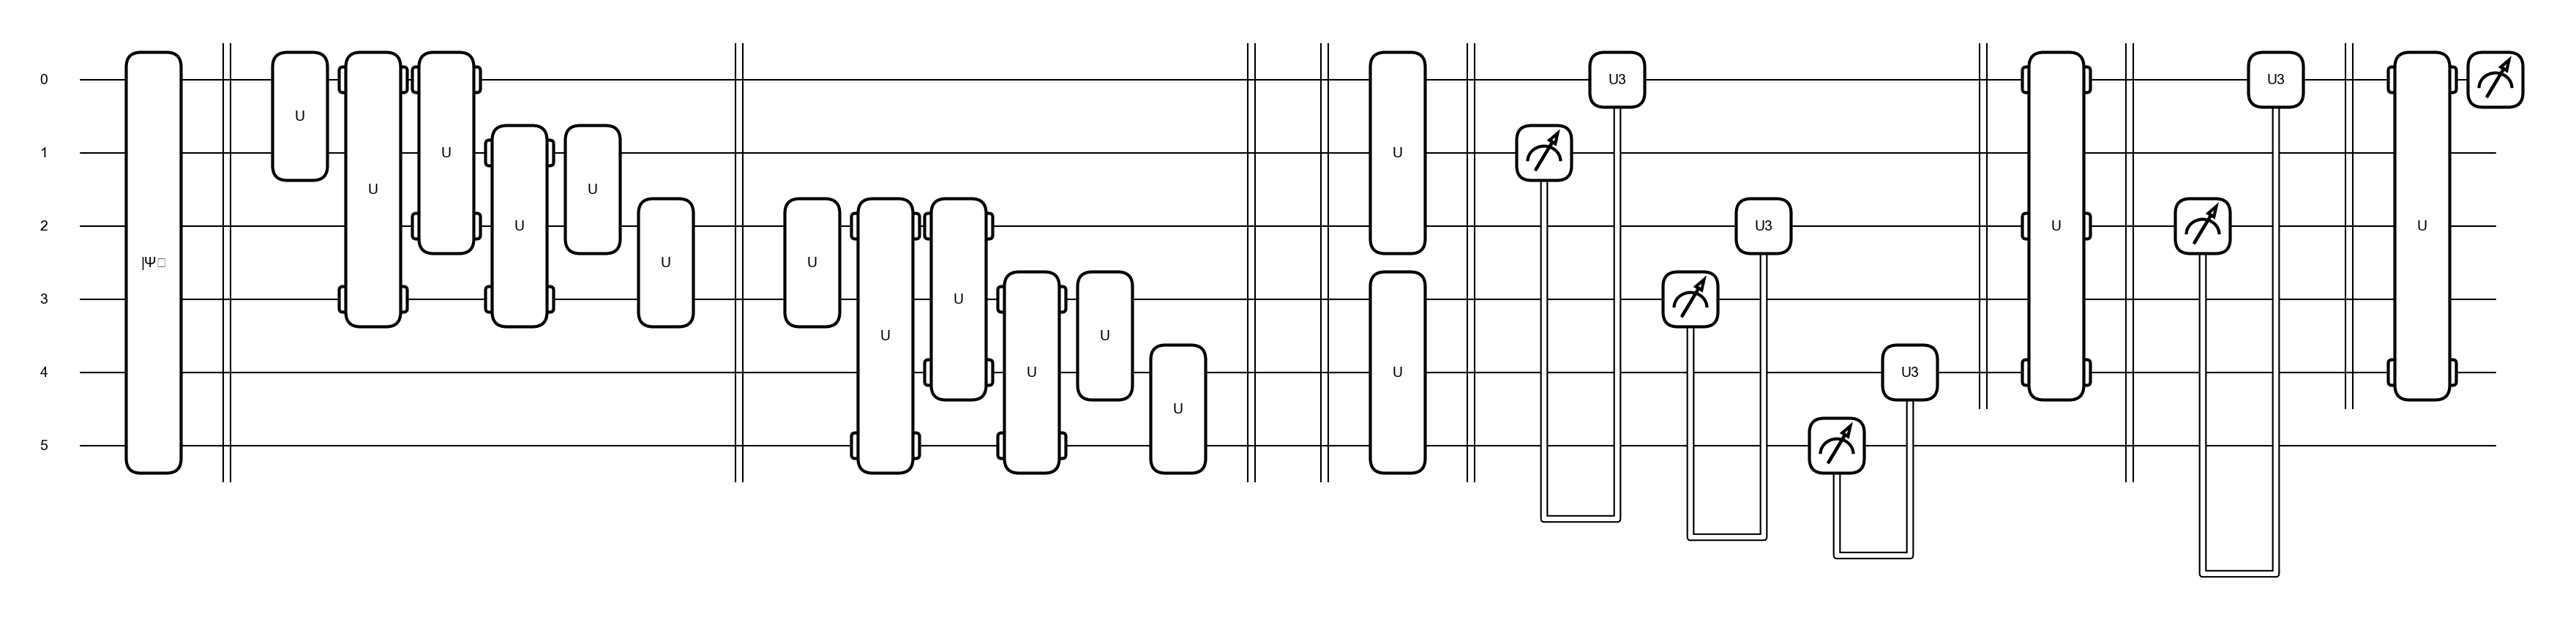

In [77]:
def conv_and_pooling(kernel_weights, n_wires, skip_first_layer=True):
    """Apply both the convolutional and pooling layer."""

    if skip_first_layer: 
        three_conv_layer(kernel_weights[15:78], n_wires, barrier=True)  
    else: 
        four_conv_layer(kernel_weights[:15], n_wires, barrier=True)
        three_conv_layer(kernel_weights[15:78], n_wires, barrier=True)
    #convolutional_layer(kernel_weights[:15], n_wires, skip_first_layer=skip_first_layer)
    pooling_layer(kernel_weights[78:], n_wires)


def dense_layer(weights, wires):
    """Apply an arbitrary unitary gate to a specified set of wires."""
    # Generate Gell-Mann matrices for vector space:
    fc_mats = generate_gell_mann(2**len(wires))
    fc_op = get_conv_op(fc_mats, weights)

    # Apply Fully Connected Operator to active qubits:
    qml.QubitUnitary(fc_op, wires=wires)


num_wires = 6
#device = qml.device("default.mixed", wires=num_wires)
device = qml.device("default.qubit", wires=num_wires)


@qml.qnode(device)
def conv_net(weights, last_layer_weights, features):
    """Define the QCNN circuit
    Args:
        weights (np.array): Parameters of the convolution and pool layers.
        last_layer_weights (np.array): Parameters of the last dense layer.
        features (np.array): Input data to be embedded using AmplitudEmbedding."""

    layers = weights.shape[1]
    wires = list(range(num_wires))

    # inputs the state input_state
    #qml.QubitDensityMatrix(features, wires=wires)
    qml.AmplitudeEmbedding(features=features, wires=wires, pad_with=0.5)
    qml.Barrier(wires=wires, only_visual=True)


    # adds convolutional and pooling layers
    for j in range(layers):
        conv_and_pooling(weights[:, j], wires, skip_first_layer=(not j == 0))
        wires = wires[::2]
        qml.Barrier(wires=wires, only_visual=True)

    assert last_layer_weights.size == 4 ** (len(wires)) - 1, (
        "The size of the last layer weights vector is incorrect!"
        f" \n Expected {4 ** (len(wires)) - 1}, Given {last_layer_weights.size}"
    )
    dense_layer(last_layer_weights, wires)
    return qml.probs(wires=(0))


fig, ax = qml.draw_mpl(conv_net)(
    np.random.rand(81, 2), np.random.rand(4 ** 2 - 1), np.random.rand(2 ** num_wires)
)
plt.show()

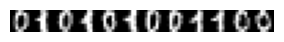

In [78]:
digits = datasets.load_digits()
images, labels = digits.data, digits.target

images = images[np.where((labels == 0) | (labels == 1))]
#images = np.pad(images, (0, 2**num_wires - len(images[0])), constant_values=0)
labels = labels[np.where((labels == 0) | (labels == 1))]

fig, axes = plt.subplots(nrows=1, ncols=12, figsize=(3, 1))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].reshape((8,8)), cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [79]:
def load_digits_data(num_train, num_test, rng):
    """Return training and testing data of digits dataset."""
    digits = datasets.load_digits()
    features, labels = digits.data, digits.target

    # only use first two classes
    features = features[np.where((labels == 0) | (labels == 1))]
    labels = labels[np.where((labels == 0) | (labels == 1))]

    # normalize data
    features = features / np.linalg.norm(features, axis=1).reshape((-1, 1))

    # subsample train and test split
    train_indices = rng.choice(len(labels), num_train, replace=False)
    test_indices = rng.choice(
        np.setdiff1d(range(len(labels)), train_indices), num_test, replace=False
    )

    x_train, y_train = features[train_indices], labels[train_indices]
    x_test, y_test = features[test_indices], labels[test_indices]

    return (
        jnp.asarray(x_train),
        jnp.asarray(y_train),
        jnp.asarray(x_test),
        jnp.asarray(y_test),
    )



In [80]:
def load_IC_data(num_train, num_test, rng):

    cascade_files = glob("/Users/pavelzhelnin/Downloads/1024_length/cascades/*.npy") # CHANGE USER
    track_files = glob("/Users/pavelzhelnin/Downloads/1024_length/tracks/*.npy") # CHANGE USER

    # # subsample train and test split

    cascade_sub_indices = rng.choice(len(track_files), len(track_files), replace = False)
    cascade_sub = np.array(cascade_files)[cascade_sub_indices]
    tracks_cascades = np.concatenate((cascade_sub,np.array(track_files)),axis=0)
    labels = np.concatenate((np.zeros(len(cascade_sub)),np.ones(len(track_files))),axis=0)

    len_labels = len(cascade_sub) + len(track_files)

    train_indices = rng.choice(len_labels, num_train, replace=False)
    test_indices = rng.choice(
        np.setdiff1d(range(len_labels), train_indices), num_test, replace=False
    )

    test_labels = labels[test_indices]
    train_labels = labels[train_indices]

    test_data = jsp.BCOO.fromdense(jnp.array([np.load(tracks_cascades[i], allow_pickle=True).tolist().todense() for i in test_indices]),n_batch=2)
    train_data = jsp.BCOO.fromdense(jnp.array([np.load(tracks_cascades[i], allow_pickle=True).tolist().todense() for i in train_indices]),n_batch=2)
        
    x_train = train_data
    y_train = train_labels
    x_test = test_data
    y_test = test_labels

    print(test_data.shape)
    return (
       x_train,jnp.asarray(y_train),x_test,jnp.asarray(y_test)
    )
    

In [81]:
# def compute_out(weights,weights_last,features,labels): 
#     cost = [conv_net(weights, weights_last, feature) for feature in features] 
#     return cost 

# def compute_accuracy(weights,weights_last,features,labels):
#     out = compute_out(weights,weights_last,features,labels)
#     return np.sum(out > 0.5) / len(out)

# def compute_cost(weights, weights_last, features, labels):
#     """Computes the cost over the provided features and labels"""
#     out = compute_out(weights, weights_last, features, labels)
#     return 1.0 - np.sum(out) / len(labels)


# def init_weights():
#     """Initializes random weights for the QCNN model."""
#     weights = np.random.normal(loc=0, scale=1, size=(18, 2), requires_grad=True)
#     weights_last = np.random.normal(loc=0, scale=1, size=4 ** 2 - 1, requires_grad=True)
#     return np.array(weights), np.array(weights_last)


In [82]:
def load_moments(num_train, num_test, rng): 
    cascade_files = glob("/Users/pavelzhelnin/Documents/physics/qcml/vqc/cascade_moments/*.npy")
    track_files = glob("/Users/pavelzhelnin/Documents/physics/qcml/vqc/track_moments/*.npy")
    x_track_train = []
    y_track_train = []
    for f in track_files:
        data = jnp.load(f, allow_pickle=True)
        x_track_train.append(data/jnp.linalg.norm(data))
        y_track_train.append(1)

    x_cascade_train = []  
    y_cascade_train = []
    for f in cascade_files:
        data = jnp.load(f, allow_pickle=True)
        x_cascade_train.append(data/jnp.linalg.norm(data))
        y_cascade_train.append(0)

    features = x_track_train + x_cascade_train
    labels = y_track_train + y_cascade_train

    # subsample train and test split
    train_indices = rng.choice(len(labels), num_train, replace=False)
    test_indices = rng.choice(
        np.setdiff1d(range(len(labels)), train_indices), num_test, replace=False
    )

    x_train = np.array([features[i] for i in train_indices])
    y_train = np.array([labels[i] for i in train_indices])
    x_test = np.array([features[i] for i in test_indices])
    y_test = np.array([labels[i] for i in test_indices])

    return (
        jnp.asarray(x_train),
        jnp.asarray(y_train),
        jnp.asarray(x_test),
        jnp.asarray(y_test),
    )
    

In [83]:
@jax.jit
def compute_out(weights, weights_last, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    cost = lambda weights, weights_last, feature, label: conv_net(weights, weights_last, feature)[
        label
    ]
    return jax.vmap(cost, in_axes=(None, None, 0, 0), out_axes=0)(
        weights, weights_last, features, labels
    )


def compute_accuracy(weights, weights_last, features, labels):
    """Computes the accuracy over the provided features and labels"""
 
    out = compute_out(weights, weights_last, features, labels)
    return jnp.sum(out > 0.5) / len(out)


def compute_cost(weights, weights_last, features, labels):
    """Computes the cost over the provided features and labels"""
    out = compute_out(weights, weights_last, features, labels)
    return 1.0 - jnp.sum(out) / len(labels)


def init_weights():
    """Initializes random weights for the QCNN model."""
    weights = pnp.random.normal(loc=0, scale=1, size=(81, 2), requires_grad=True)
    weights_last = pnp.random.normal(loc=0, scale=1, size=4 ** 2 - 1, requires_grad=True)
    return jnp.array(weights), jnp.array(weights_last)


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0, 1]))

In [84]:
def train_qcnn(n_train, n_test, n_epochs):
    
    x_train, y_train, x_test, y_test = load_digits_data(n_train, n_test, rng)
    #x_train, y_train, x_test, y_test = load_moments(n_train, n_test, rng)
    #x_train, y_train, x_test, y_test = load_IC_data(n_train, n_test, rng)


    weights, weights_last = init_weights()

    cosine_decay_scheduler = optax.cosine_decay_schedule(0.1, decay_steps=n_epochs, alpha=0.95)
    optimizer = optax.adam(learning_rate=cosine_decay_scheduler)
    opt_state = optimizer.init((weights, weights_last))

    train_cost_epochs, test_cost_epochs, train_acc_epochs, test_acc_epochs = [], [], [], []

    for step in range(n_epochs):
        train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
        updates, opt_state = optimizer.update(grad_circuit, opt_state)
        weights, weights_last = optax.apply_updates((weights, weights_last), updates)

        train_cost_epochs.append(train_cost)

        train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
        train_acc_epochs.append(train_acc)

        test_out = compute_out(weights, weights_last, x_test, y_test)
        test_acc = jnp.sum(test_out > 0.5) / len(test_out)
        test_acc_epochs.append(test_acc)
        test_cost = 1.0 - jnp.sum(test_out) / len(test_out)
        test_cost_epochs.append(test_cost)

    return dict(
        n_train=[n_train] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int),
        train_cost=train_cost_epochs,
        train_acc=train_acc_epochs,
        test_cost=test_cost_epochs,
        test_acc=test_acc_epochs,
    )

In [85]:
n_test = 2
n_epochs = 100
n_reps = 10

def run_iterations(n_train):
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]
    )

    for _ in range(n_reps):
        results = train_qcnn(n_train=n_train, n_test=n_test, n_epochs=n_epochs)
        results_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
        )

    return results_df


n_test = 2
n_epochs = 100
n_reps = 10
# run training for multiple sizes
# train_sizes = [2, 5, 10, 20, 40, 80]
train_sizes = [2]
results_df = run_iterations(n_train=2)
for n_train in train_sizes[1:]:
    results_df = pd.concat([results_df, run_iterations(n_train=n_train)])

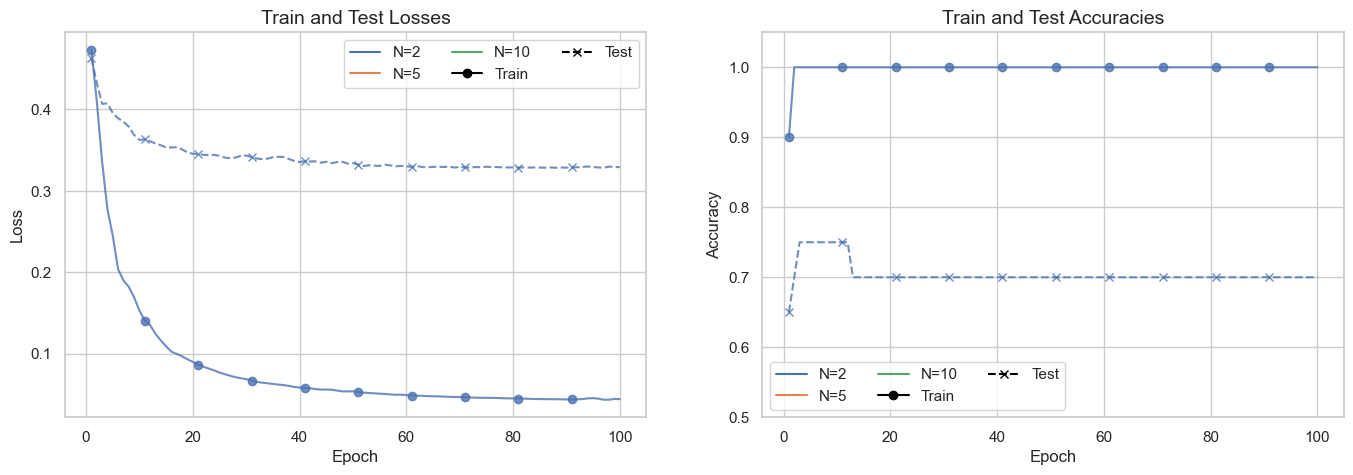

In [86]:
# aggregate dataframe
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"])
df_agg = df_agg.reset_index()

sns.set_style('whitegrid')
colors = sns.color_palette()
fig, axes = plt.subplots(ncols=2, figsize=(16.5, 5))

generalization_errors = []
train_sizes = [2, 5, 10]
# plot losses and accuracies
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train]

    dfs = [df.train_cost["mean"], df.test_cost["mean"], df.train_acc["mean"], df.test_acc["mean"]]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0,0,1,1]

    for k in range(4):
        ax = axes[axs[k]]
        ax.plot(df.step, dfs[k], lines[k], label=labels[k], markevery=10, color=colors[i], alpha=0.8)


    # plot final loss difference
    dif = df[df.step == 100].test_cost["mean"] - df[df.step == 100].train_cost["mean"]
    generalization_errors.append(dif)

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# format generalization error plot
# ax = axes[1]
# ax.plot(train_sizes, generalization_errors, "o-", label=r"$gen(\alpha)$")
# ax.set_xscale('log')
# ax.set_xticks(train_sizes)
# ax.set_xticklabels(train_sizes)
# ax.set_title(r'Generalization Error $gen(\alpha) = R(\alpha) - \hat{R}_N(\alpha)$', fontsize=14)
# ax.set_xlabel('Training Set Size')

# format loss plot
ax = axes[1]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5, 1.05)

legend_elements = [
    mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)
    ] + [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='Black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='Black')
    ]

axes[0].legend(handles=legend_elements, ncol=3)
axes[1].legend(handles=legend_elements, ncol=3)

#axes[1].set_yscale('log', base=2)
plt.show()

In [87]:
@jax.jit
def compute_out(weights, weights_last, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    cost = lambda weights, weights_last, feature, label: conv_net(weights, weights_last, feature)[
        label
    ]
    return jax.vmap(cost, in_axes=(None, None, 0, 0), out_axes=0)(
        weights, weights_last, features, labels
    )


def compute_accuracy(weights, weights_last, features, labels):
    """Computes the accuracy over the provided features and labels"""
 
    out = compute_out(weights, weights_last, features, labels)
    return jnp.sum(out > 0.5) / len(out)


def compute_cost(weights, weights_last, features, labels):
    """Computes the cost over the provided features and labels"""
    out = compute_out(weights, weights_last, features, labels)
    return 1.0 - jnp.sum(out) / len(labels)


def init_weights():
    """Initializes random weights for the QCNN model."""
    weights = pnp.random.normal(loc=0, scale=1, size=(81, 1), requires_grad=True)
    weights_last = pnp.random.normal(loc=0, scale=1, size=4 ** 3 - 1, requires_grad=True) # originally size = 4 ** 3 - 1(results in 63 vs 15 error)
    return jnp.array(weights), jnp.array(weights_last)


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0, 1]))

In [88]:
num_train=2
num_test=2
cascade_files = glob("/Users/pavelzhelnin/Documents/physics/qcml/vqc/spacetime_cascades/*.npz")
track_files = glob("/Users/pavelzhelnin/Documents/physics/qcml/vqc/spacetime_tracks/*.npz")
x_track_train = []
y_track_train = []
for f in track_files:
    data = np.load(f, allow_pickle=True)['arr_0'] 
    if data.tolist().shape[0] == 1024:
        x_track_train.append(data.tolist())
        y_track_train.append(1)

x_cascade_train = []  
y_cascade_train = []
for f in cascade_files:
    data = np.load(f, allow_pickle=True)['arr_0']
    if data.tolist().shape[0] == 1024:
        x_cascade_train.append(data.tolist())
        y_cascade_train.append(0)
    
features = x_track_train + x_cascade_train
labels = y_track_train + y_cascade_train


# subsample train and test split
train_indices = rng.choice(len(labels), num_train, replace=False)
test_indices = rng.choice(
    np.setdiff1d(range(len(labels)), train_indices), num_test, replace=False
)

x_train = [jsp.BCSR.from_scipy_sparse(features[i]) for i in train_indices]
y_train = np.array([labels[i] for i in train_indices])
x_test = [jsp.BCSR.from_scipy_sparse(features[i]) for i in test_indices]
y_test = np.array([labels[i] for i in test_indices])

ValueError: a must be a positive integer unless no samples are taken

In [ ]:
a = x_train[0]

In [ ]:
a.n_batch = 1

In [ ]:
print(type(a))

In [ ]:
b = jsp.BCSR(a, n_batch=1)

In [ ]:
hstack(features[train_indices[0]],features[train_indices[1]])

In [ ]:
import scipy as sp 

In [ ]:
jsp.BCOO.fromdense(jnp.array([features[train_indices[0]].todense(),features[train_indices[1]].todense()])).indices.ndim 

In [ ]:
jsp.bcoo_concatenate(jnp.asarray(jsp.BCSR.from_scipy_sparse(features[train_indices[0]]).to_bcoo(),jsp.BCSR.from_scipy_sparse(features[train_indices[1]]).to_bcoo()),0)

In [ ]:
full_array = jnp.array(
        [
            [
                [0,0,0],
                [2,2,2],
                [0,0,0],
                [0,0,0]
            ],
            [
                [1,1,1],
                [0,0,0],
                [0,0,0],
                [0,0,0]
            ],
            [
                [1,1,1],
                [0,0,0],
                [0,0,0],
                [0,0,0]
            ]
        ]
)

In [ ]:
sparse_array = jsp.bcoo_fromdense(full_array)

In [ ]:
sparse_array.indices 

In [ ]:
cascade_files = glob("/Users/pavelzhelnin/Documents/physics/qcml/vqc/spacetime_cascades/*.npz")
track_files = glob("/Users/pavelzhelnin/Documents/physics/qcml/vqc/spacetime_tracks/*.npz")
x_track_train = []
y_track_train = []
for f in track_files:
    data = np.load(f, allow_pickle=True)['arr_0'] 
    if data.tolist().shape[0] == 1024:
        filename = "1024_length/tracks/" + f.split("/")[-1].split(".")[0] + ".npy"
        np.save(filename,data)
        y_track_train.append(1)

x_cascade_train = []  
y_cascade_train = []
for f in cascade_files:
    data = np.load(f, allow_pickle=True)['arr_0']
    if data.tolist().shape[0] == 1024:
        filename = "1024_length/cascades/" + f.split("/")[-1].split(".")[0] + ".npy"
        np.save(filename,data)
        y_cascade_train.append(0)

In [ ]:
len(y_track_train)

In [ ]:
start = time.time() 
cascade_files = glob("/Users/pavelzhelnin/Downloads/1024_length/cascades/*.npy")
track_files = glob("/Users/pavelzhelnin/Downloads/1024_length/tracks/*.npy")

num_train = 2 
num_test = 2
# # subsample train and test split

cascade_sub_indices = rng.choice(len(track_files), len(track_files), replace = False)
cascade_sub = np.array(cascade_files)[cascade_sub_indices]
tracks_cascades = np.concatenate((cascade_sub,np.array(track_files)),axis=0)
labels = np.concatenate((np.zeros(len(cascade_sub)),np.ones(len(track_files))),axis=0)

len_labels = len(cascade_sub) + len(track_files)

train_indices = rng.choice(len_labels, num_train, replace=False)
test_indices = rng.choice(
    np.setdiff1d(range(len_labels), train_indices), num_test, replace=False
)

test_labels = labels[test_indices]
train_labels = labels[train_indices]

test_data = jsp.BCOO.fromdense(jnp.array([np.load(tracks_cascades[i], allow_pickle=True).tolist().todense() for i in test_indices]),n_batch=1)
train_data = jsp.BCOO.fromdense(jnp.array([np.load(tracks_cascades[i], allow_pickle=True).tolist().todense() for i in train_indices]),n_batch=1)

print(time.time()-start) 
# features = x_track_train + x_cascade_train
# labels = y_track_train + y_cascade_train


# x_train = [jsp.BCSR.from_scipy_sparse(features[i]) for i in train_indices]
# y_train = np.array([labels[i] for i in train_indices])
# x_test = [jsp.BCSR.from_scipy_sparse(features[i]) for i in test_indices]
# y_test = np.array([labels[i] for i in test_indices])


# x_train,jnp.asarray(y_train),x_test,jnp.asarray(y_test)


In [ ]:
a = np.load(tracks_cascades[i], allow_pickle=True).tolist()
b = np.load(tracks_cascades[2], allow_pickle=True).tolist()
print(a.tocoo().row)


In [ ]:
row = a.tocoo().row
col = a.tocoo().col 
data = a.tocoo().data 

row_b = b.tocoo().row
col_b = b.tocoo().col
data_b = b.tocoo().data


In [ ]:
np.shape(np.array([data_b,data]))

In [ ]:
jsp.BCOO((jnp.array([data),np.column_stack((row,col))),shape=(1024,1024))

In [ ]:
jsp.BCOO((jnp.array([1.]),jnp.array([[0,0]])),shape=(1024,1024))

In [ ]:
c = np.vstack((row,col))

In [ ]:
.shape 